# Example Climb: Creating Non-Linear Monotonic Relationships

## Goal: Maximize Spearman while minimizing Pearson

This notebook demonstrates using the hill climber to transform data to have a strong monotonic relationship (high Spearman correlation) while maintaining a weak linear relationship (low Pearson correlation). This creates non-linear but monotonic patterns.

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr

sys.path.append('..')

from hill_climber import HillClimber

np.random.seed(315)

### 1.2. Input distributions

Initial state:
  Pearson correlation:  -0.0180 (linear relationship)
  Spearman correlation: -0.0128 (monotonic relationship)
  Objective: -0.0052


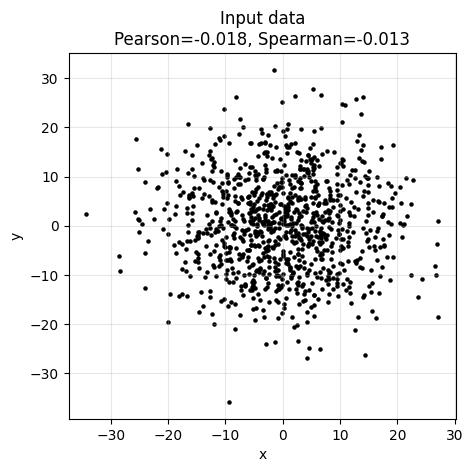

In [2]:
n = 1000
np.random.seed(315)

x = np.random.normal(0, 10, n)
y = np.random.normal(0, 10, n)

data = pd.DataFrame({'x': x, 'y': y})

# Check initial correlations
initial_pearson = pearsonr(data['x'], data['y'])[0]
initial_spearman = spearmanr(data['x'], data['y'])[0]

print(f"Initial state:")
print(f"  Pearson correlation:  {initial_pearson:.4f} (linear relationship)")
print(f"  Spearman correlation: {initial_spearman:.4f} (monotonic relationship)")
print(f"  Objective: {abs(initial_spearman) - abs(initial_pearson):.4f}")

plt.figure(figsize=(5, 4.75))
plt.scatter(data['x'], data['y'], s=5, color='black')
plt.title(f'Input data\nPearson={initial_pearson:.3f}, Spearman={initial_spearman:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Optimize for non-linear monotonic relationship
### 2.1. Objective function

**Objective:** Maximize |Spearman| - |Pearson|

This works because:
- Spearman measures rank correlation (monotonic relationship)
- Pearson measures linear correlation
- Maximizing the gap creates non-linear but monotonic patterns
- Small beneficial perturbations accumulate over thousands of iterations
- Hill climber keeps changes that increase the gap, rejects those that don't

In [3]:
def objective_spearman_large_pearson_small(x, y):
    '''Maximize |Spearman| - |Pearson| to create non-linear monotonic relationships.
    
    Objective function: |Spearman| - |Pearson|
    
    This creates a gradient that:
        - Rewards increasing monotonicity (Spearman)
        - Penalizes increasing linearity (Pearson)
        - Works for both positive and negative correlations
        - Accumulates small beneficial changes over time
    
    Args:
        x: First variable (array-like)
        y: Second variable (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with 'PCC' and 'SCC'
            - objective_value: |Spearman| - |Pearson|
    '''
    
    pearson_corr = pearsonr(x, y)[0]
    spearman_corr = spearmanr(x, y)[0]
    
    # Objective: maximize gap between monotonic and linear correlation
    # Use absolute values to work with both positive and negative correlations
    objective = abs(spearman_corr) - abs(pearson_corr)
    
    metrics = {
        'PCC': pearson_corr,
        'SCC': spearman_corr
    }
    
    return metrics, objective

### 2.2. Hill climbing run

In [ ]:
climber = HillClimber(
    data=data,
    objective_func=objective_spearman_large_pearson_small,
    max_time=30,
    perturb_fraction=0.1,
    step_spread=0.2,
    T_min=1e-6,
    T_max=1e-2,
    n_replicas=8,
    exchange_interval=1000,
    exchange_strategy='random',
    cooling_rate=1e-8,
    db_enabled=True,
    db_step_interval=250,
    db_path='../data/pearson_spearman.db',
    checkpoint_file='../data/pearson_spearman.pkl'
)

In [5]:
# Run optimization with replica exchange
best_data, history_df = climber.climb()

### 2.3. Resume for extended optimization

In [6]:
# Resume the climb for another 4 hours
best_data, history_df = climber.climb()

In [9]:
climber.db_step_interval

1

### 2.4. Results

/workspaces/hill_climber/notebooks/../hill_climber/plotting_functions.py:312: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


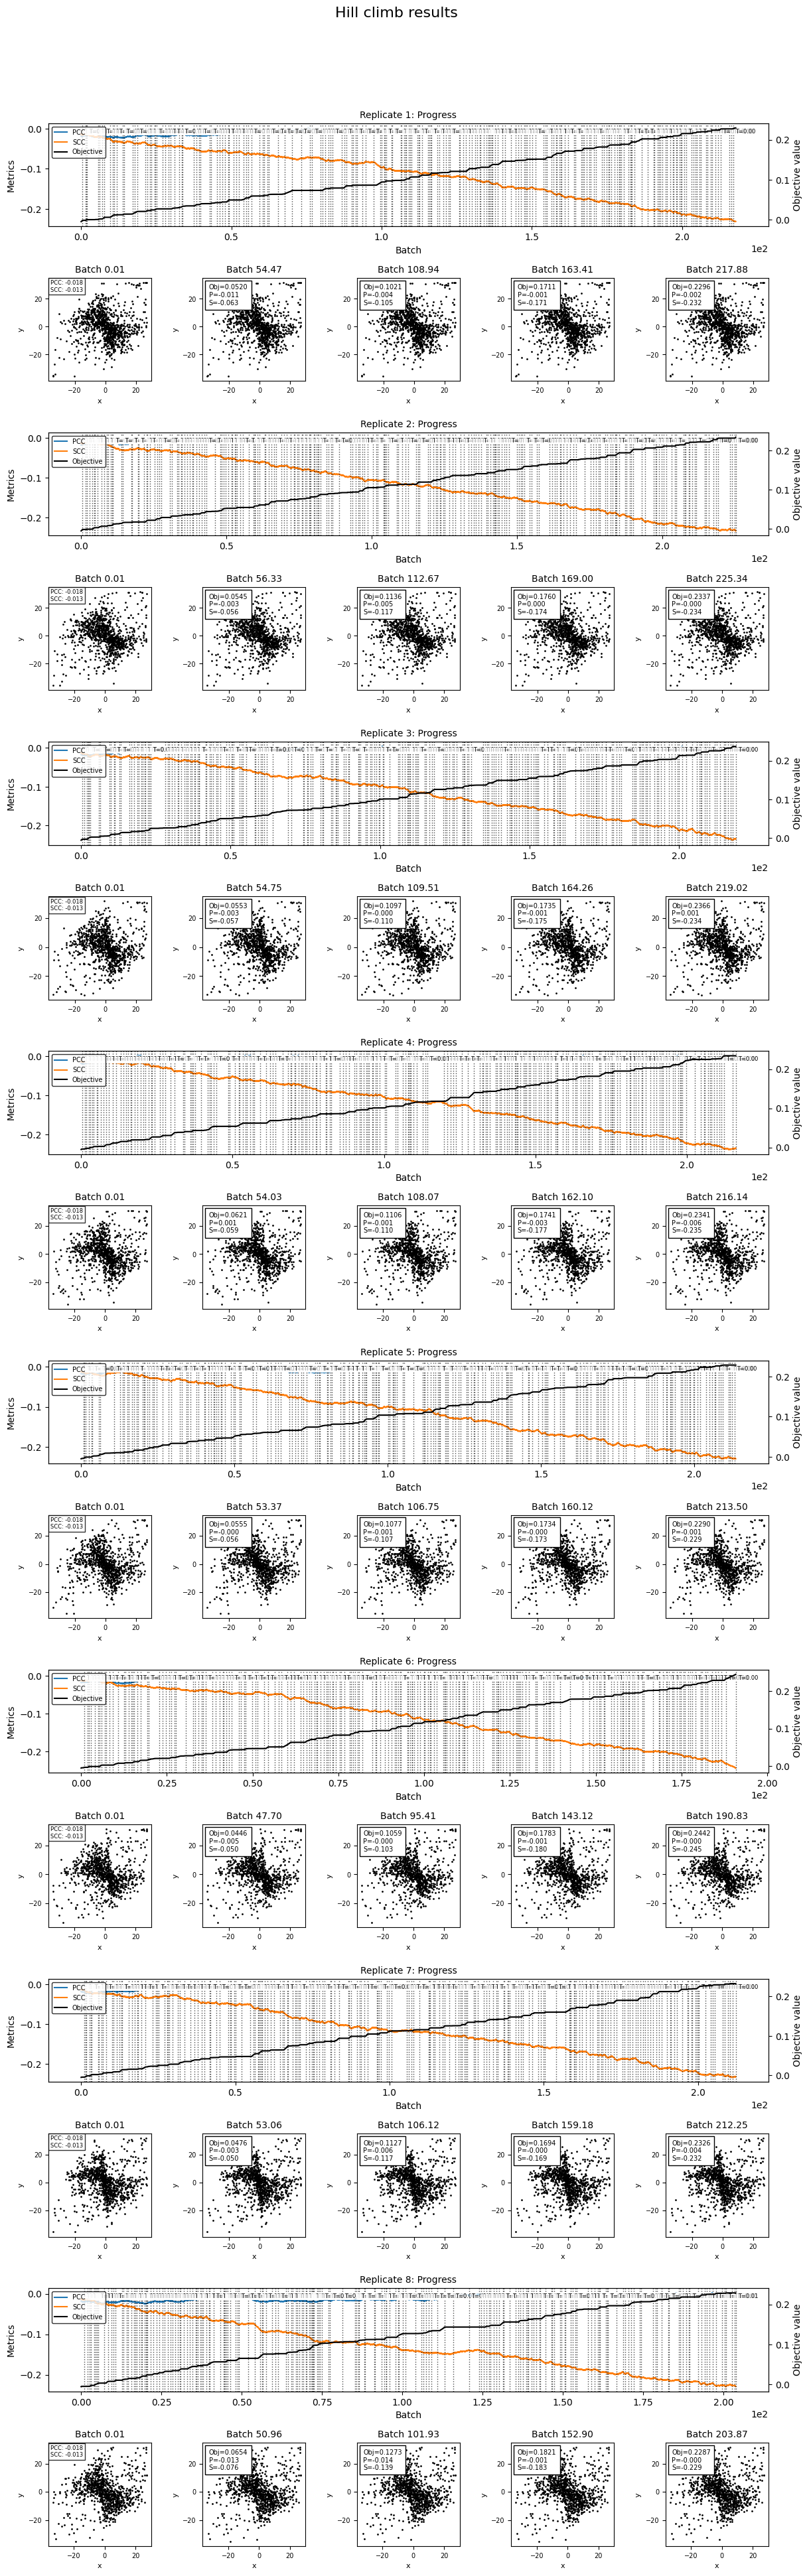


Final correlations:
Pearson:  -0.0180 → -0.0003 (change: +0.0178)
Spearman: -0.0128 → -0.2445 (change: -0.2316)
Objective: -0.0052 → 0.2442 (change: +0.2494)


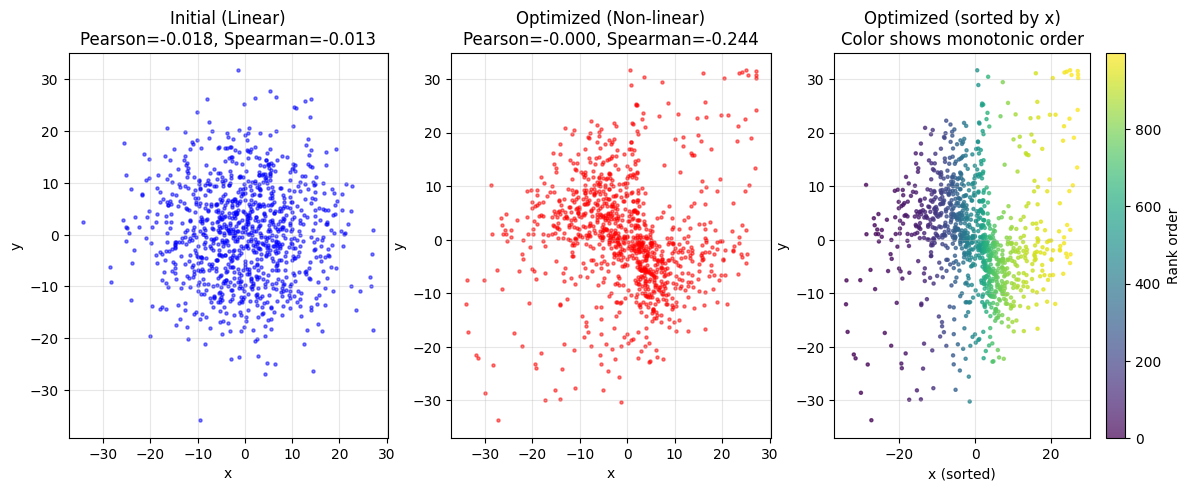


Interpretation:
✓ Success! Objective improved by 0.249
  - Spearman change: -0.232
  - Pearson change: +0.018
  - Created non-linear monotonic relationship (gap: 0.244)
  - Pattern is monotonic but not linear (e.g., exponential, logarithmic)


In [8]:
from hill_climber import plot_optimization_results

# Plot optimization progress
plot_optimization_results(
    source='../data/pearson_spearman.pkl',
    plot_type='scatter',
    metrics=['PCC', 'SCC'],  # Show Pearson and Spearman correlation coefficients
    all_replicas=True,
    show_current=False  # Show only best objective (accepted steps)
)

# Show final results
print("\nFinal correlations:")
final_pearson = pearsonr(best_data['x'], best_data['y'])[0]
final_spearman = spearmanr(best_data['x'], best_data['y'])[0]
final_objective = abs(final_spearman) - abs(final_pearson)
initial_objective = abs(initial_spearman) - abs(initial_pearson)

print(f"Pearson:  {initial_pearson:.4f} → {final_pearson:.4f} (change: {final_pearson - initial_pearson:+.4f})")
print(f"Spearman: {initial_spearman:.4f} → {final_spearman:.4f} (change: {final_spearman - initial_spearman:+.4f})")
print(f"Objective: {initial_objective:.4f} → {final_objective:.4f} (change: {final_objective - initial_objective:+.4f})")

# Plot final data
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(data['x'], data['y'], s=5, color='blue', alpha=0.5)
plt.title(f'Initial (Linear)\nPearson={initial_pearson:.3f}, Spearman={initial_spearman:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(best_data['x'], best_data['y'], s=5, color='red', alpha=0.5)
plt.title(f'Optimized (Non-linear)\nPearson={final_pearson:.3f}, Spearman={final_spearman:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)

# Add sorted view to see monotonicity
plt.subplot(1, 3, 3)
sorted_idx = np.argsort(best_data['x'])
plt.scatter(best_data['x'].iloc[sorted_idx], best_data['y'].iloc[sorted_idx], 
            s=5, c=range(len(sorted_idx)), cmap='viridis', alpha=0.7)
plt.title(f'Optimized (sorted by x)\nColor shows monotonic order')
plt.xlabel('x (sorted)')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.colorbar(label='Rank order')
plt.show()

print("\nInterpretation:")
improvement = final_objective - initial_objective
gap = abs(final_spearman) - abs(final_pearson)

if improvement > 0.05:
    print(f"✓ Success! Objective improved by {improvement:.3f}")
    print(f"  - Spearman change: {final_spearman - initial_spearman:+.3f}")
    print(f"  - Pearson change: {final_pearson - initial_pearson:+.3f}")
    if gap > 0.2:
        print(f"  - Created non-linear monotonic relationship (gap: {gap:.3f})")
        print(f"  - Pattern is monotonic but not linear (e.g., exponential, logarithmic)")
    else:
        print(f"  - Moderate gap: {gap:.3f} (some non-linearity)")
elif improvement > 0:
    print(f"⚠ Modest progress: Objective improved by {improvement:.3f}")
    print("  Consider: longer runtime, larger step_spread, or more perturbations")
else:
    print(f"✗ Limited progress: Objective changed by {improvement:.3f}")
    print("  Consider: longer runtime or different parameters")